In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

def stationary_test(series):
    result = adfuller(series)
    return (result[0], result[1])

data = pd.read_csv('variable_selected_county_dataset.csv').iloc[:, 1:]

# Univariate Prophet

In [67]:
la = data[data['entity'] == 'California-Los Angeles'].loc[:, ['date', 'incremental_cases']]
la['incremental_cases'] = la['incremental_cases'].astype('int')
la['date'] = pd.to_datetime(la['date'], format="%Y-%m-%d")

# use 85%-15% for train-test split
train = la.iloc[:230, :].rename(columns = {'date':'ds', 'incremental_cases':'y'})
test = la.iloc[230:, :]

# NYC data is stationary without any differencing
print(stationary_test(train.y))

(-1.8029508843492845, 0.37899764874321873)


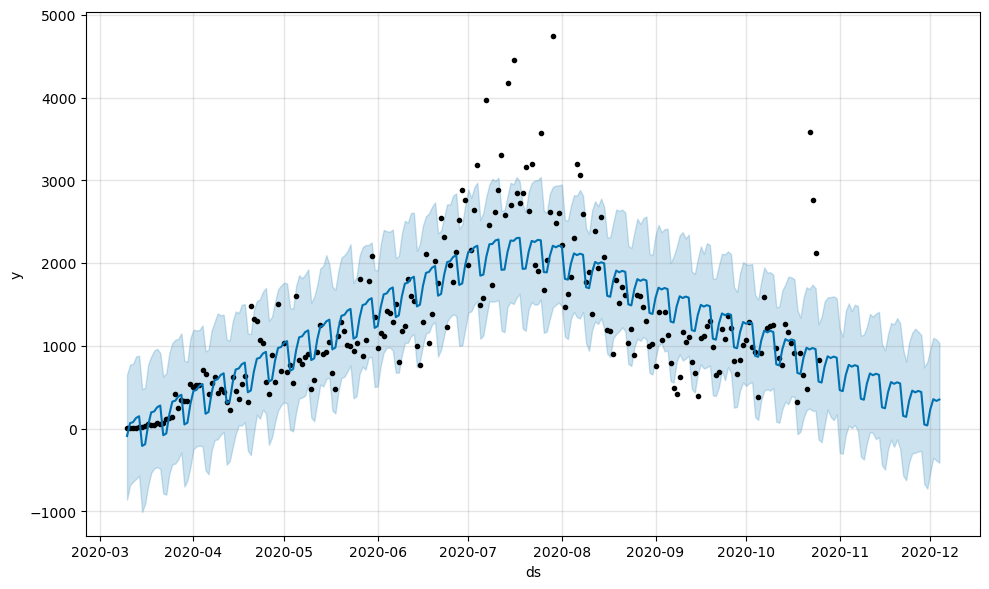

In [68]:
model = Prophet().fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

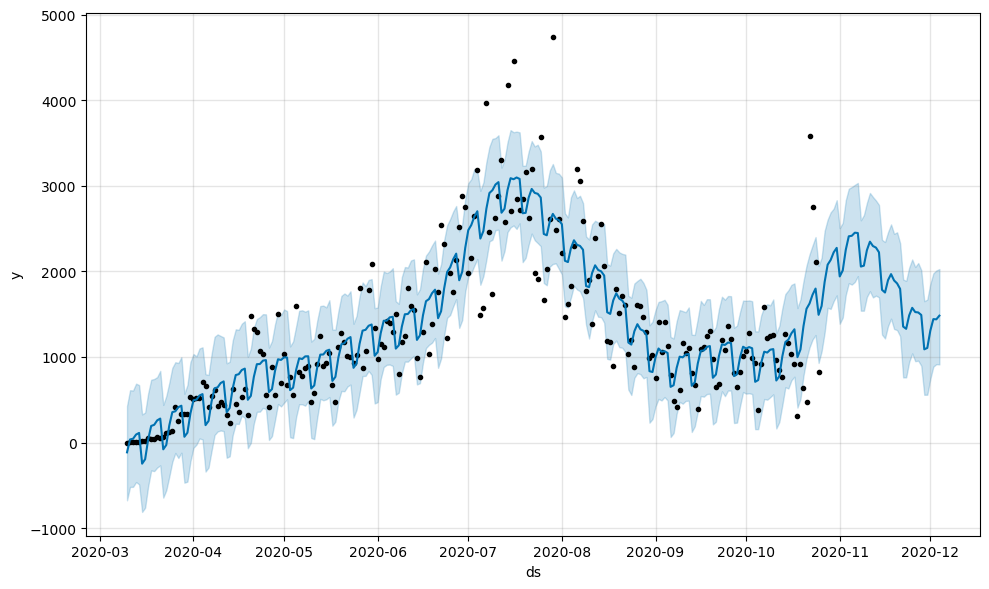

In [69]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
model.plot(pred);

-0.8465369917646917


<Axes: xlabel='date'>

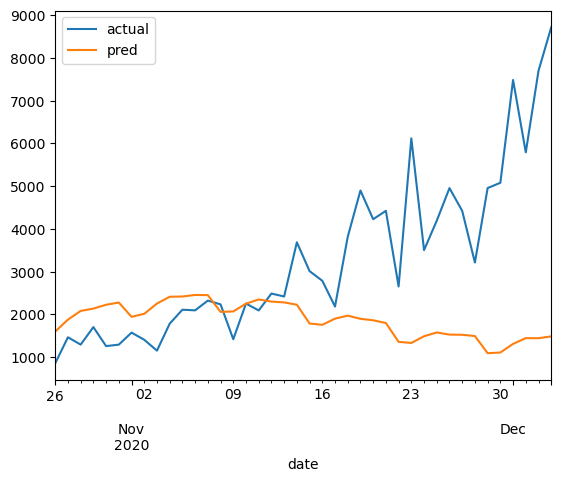

In [70]:
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [71]:
tscv = TimeSeriesSplit(n_splits = 5)

train = train.reset_index().drop(columns = 'index')

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2515661.374931142


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2549008.227127776


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2555116.203262421


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2519968.225348292


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2590998.277820321


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2715408.7394456007


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2515661.374931142


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2549008.227127776


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2555116.203262421


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2519968.225348292


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2590998.277820321


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2715408.7394456007


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2515661.374931142


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2549008.227127776


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2555116.203262421


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2519968.225348292


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2590998.277820321


Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.


params: {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0} with mean MSE: 2715408.7394456007
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01} with mean MSE: 2418958.845040474
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2331408.2697835458
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0} with mean MSE: 2361680.849348394
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01} with mean MSE: 2408804.8693858995
params: {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0

-0.38061512389434426


<Axes: xlabel='date'>

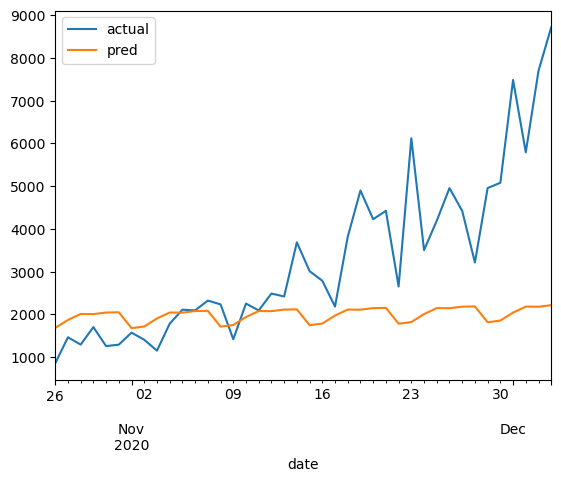

In [72]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [73]:
param_grid = {
    'changepoint_prior_scale': [0.05, 0.075, 0.1, 0.125, 0.15],
    'seasonality_prior_scale': [0.05, 0.075, 0.1, 0.125, 0.15],
    'holidays_prior_scale': [0.005, 0.01, 0.015, 0.02],
    'seasonality_mode': ['additive', 'multiplicative']
}

best_score, best_param = float("inf"), None

for param in ParameterGrid(param_grid):
    all_mse = 0
    for train_index, val_index in tscv.split(train):
      train_data, val_data = train.loc[train_index, :], train.loc[val_index, :]
      model = Prophet(**param).fit(train_data)
      pred = model.predict(val_data)
      mse = mean_squared_error(val_data.y, pred.yhat)
      all_mse = all_mse + mse
    print(f'params: {param} with mean MSE: {all_mse / 3}')
    if all_mse / 3 < best_score:
      best_score, best_param = all_mse / 3, param

print(f'Best Prophet parameters: {best_param} with mean MSE: {best_score}')

params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 2276263.670453488
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.075} with mean MSE: 2275894.461804601
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2303977.412808128
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.125} with mean MSE: 2297873.4313300694
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.15} with mean MSE: 2293875.9717888837
params: {'changepoint_prior_scale': 0.05, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05

params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.125} with mean MSE: 2582072.0953859636
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.15} with mean MSE: 2597617.97773262
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 2497813.387619369
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.075} with mean MSE: 2496857.6752954987
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2443731.9709881595
params: {'changepoint_prior_scale': 0.075, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scal

params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.075} with mean MSE: 2662436.9454726796
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2721639.322508169
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.125} with mean MSE: 2722348.2215475165
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.15} with mean MSE: 2714802.3700104444
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 2589045.8783525666
params: {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_sc

params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.125} with mean MSE: 2541230.3102901424
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.15} with mean MSE: 2524504.2867555227
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with mean MSE: 2620845.0985234925
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.075} with mean MSE: 2597835.436861801
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1} with mean MSE: 2653649.7572785537
params: {'changepoint_prior_scale': 0.125, 'holidays_prior_scale': 0.015, 'seasonality_mode': 'multiplicative', 'seas

params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.05} with mean MSE: 2328970.453219146
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.075} with mean MSE: 2318642.318345023
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1} with mean MSE: 2324095.733439274
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.125} with mean MSE: 2400459.970269472
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.15} with mean MSE: 2279356.0390906925
params: {'changepoint_prior_scale': 0.15, 'holidays_prior_scale': 0.02, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.05} with 

-1.2468538655007158


<Axes: xlabel='date'>

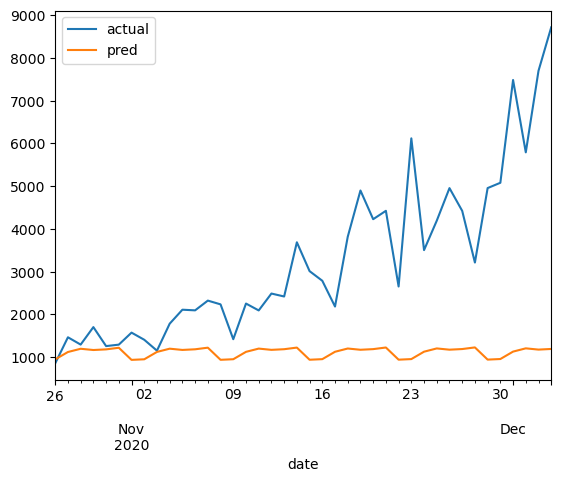

In [74]:
model = Prophet(**best_param).fit(train)
pred = model.predict(model.make_future_dataframe(periods=40))
r2 = r2_score(test.incremental_cases, pred.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.incremental_cases.reset_index(drop = True),
              'pred':pred.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['date'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

# Multivariate Prophet

In [75]:
la = data[data['entity'] == 'California-Los Angeles'].drop(columns = 'cases')
la['incremental_cases'] = la['incremental_cases'].astype('int')
la['date'] = pd.to_datetime(la['date'], format="%Y-%m-%d")
la['stay_at_home_announced'] = la['stay_at_home_announced'].map({'yes':1, 'no':0})
la['stay_at_home_effective'] = la['stay_at_home_effective'].map({'yes':1, 'no':0})

non_static = []
def static_check(df):
  for i in df.columns:
    num_unique = len(df[i].unique())
    if num_unique != 1:
      non_static.append(i)
  return non_static

static_check(la)
la = la.loc[:, non_static].drop(columns = 'station_name').rename(columns = {'date':'ds', 'incremental_cases':'y'})

train = la.iloc[:230, :]
test = la.iloc[230:, :]

In [76]:
la.columns

Index(['ds', 'stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'station_pressure', 'visibility',
       'wind_speed', 'max_wind_speed', 'precipitation', 'precip_flag', 'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg', 'y'],
      dtype='object')

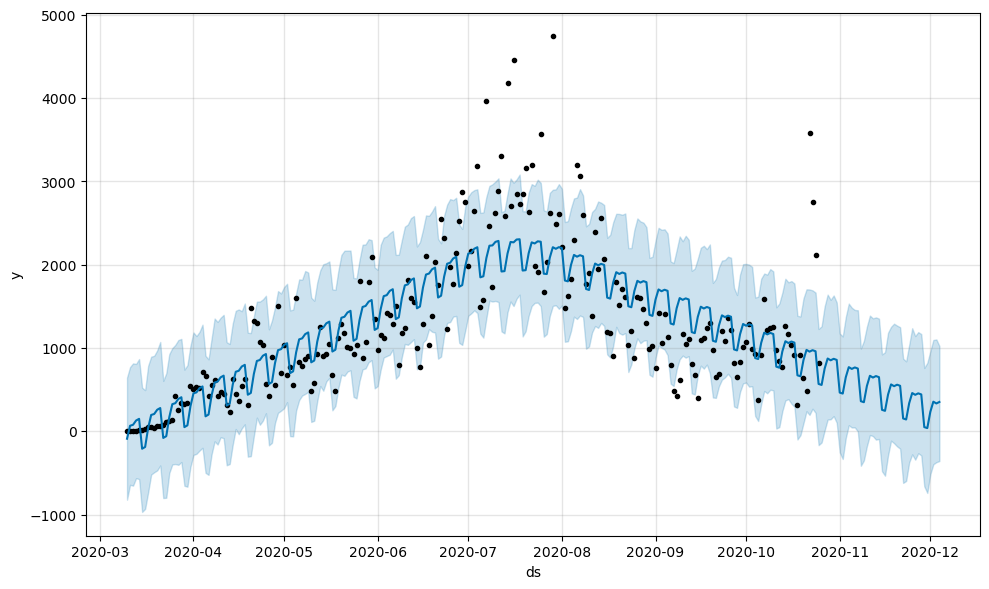

In [77]:
# baseline model
model_baseline = Prophet()
model_baseline.fit(train)

future_baseline = model_baseline.make_future_dataframe(periods=40)
forecast_baseline = model_baseline.predict(future_baseline)
model_baseline.plot(forecast_baseline);

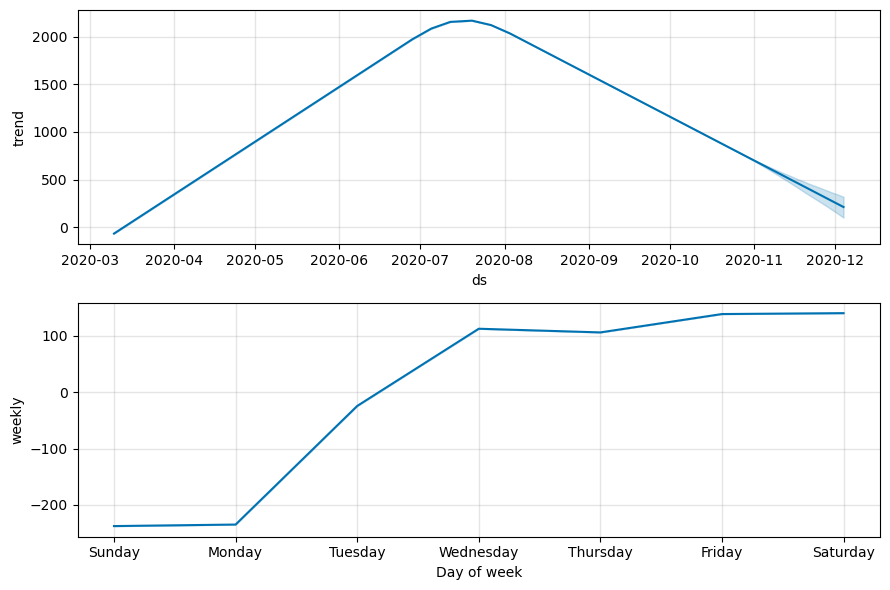

In [78]:
model_baseline.plot_components(forecast_baseline);

In [79]:
performance_baseline = pd.merge(test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 2769.927534161377
The MAPE for the baseline model is 0.7569196130573294


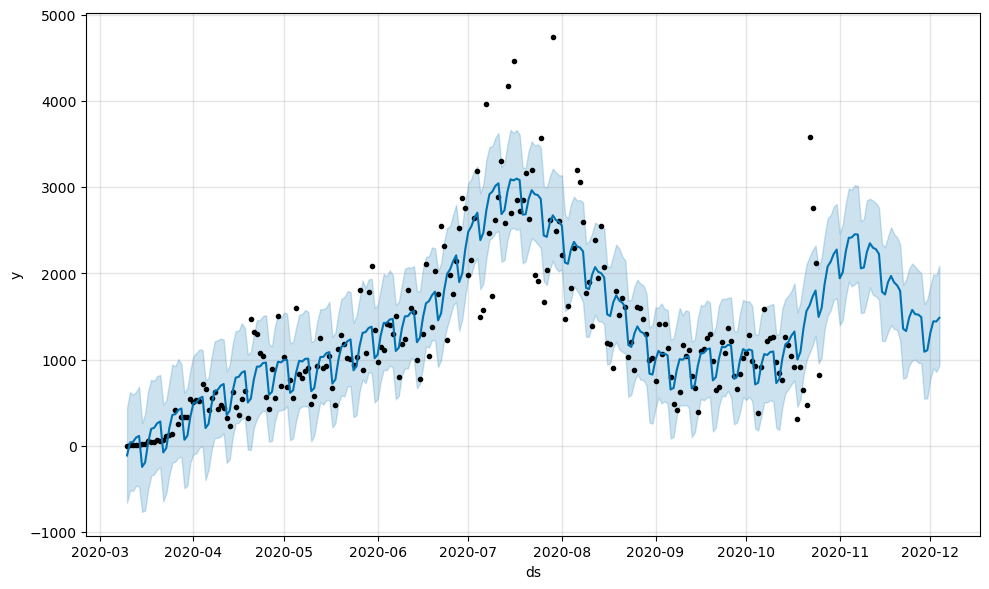

In [83]:
# Add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_season.fit(train)
future_season = model_season.make_future_dataframe(periods=40)
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season);

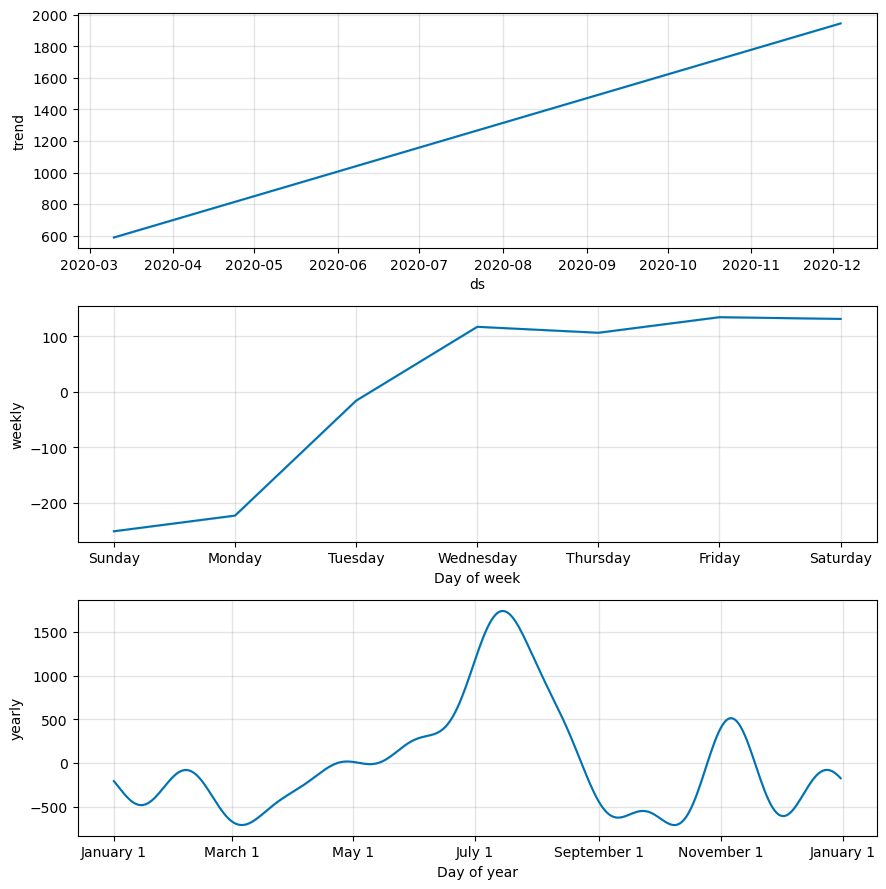

In [84]:
model_season.plot_components(forecast_season);

In [85]:
performance_season = pd.merge(test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 1841.7096338167096
The MAPE for the seasonality model is 0.4845587894552499


-0.8465369917646917


<Axes: xlabel='date'>

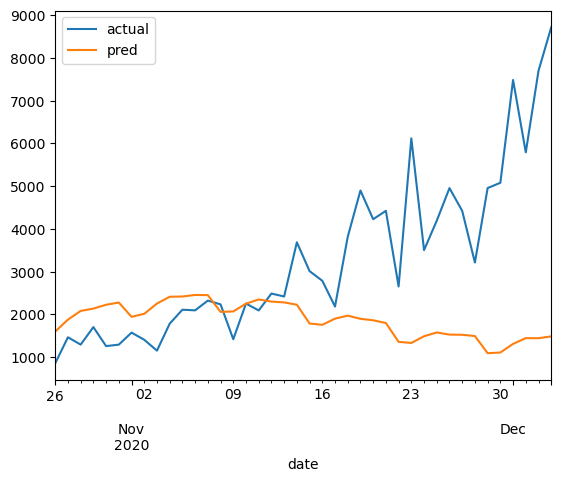

In [86]:
r2 = r2_score(test.y, forecast_season.tail(40).yhat)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':forecast_season.tail(40).yhat.reset_index(drop = True)})
prediction['date'] = test['ds'].reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [87]:
train = la.iloc[:230, :]
test = la.iloc[230:, :]
train = train.ffill()

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('stay_at_home_announced', standardize=False)
model_multivariate.fit(train)

In [88]:
# Create the time range for the forecast
future_multivariate = model_multivariate.make_future_dataframe(periods=40)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, la[['ds', 'stay_at_home_announced']], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,stay_at_home_announced
260,2020-11-25,1
261,2020-11-26,1
262,2020-11-27,1
263,2020-11-28,1
264,2020-11-29,1
265,2020-11-30,1
266,2020-12-01,1
267,2020-12-02,1
268,2020-12-03,1
269,2020-12-04,1


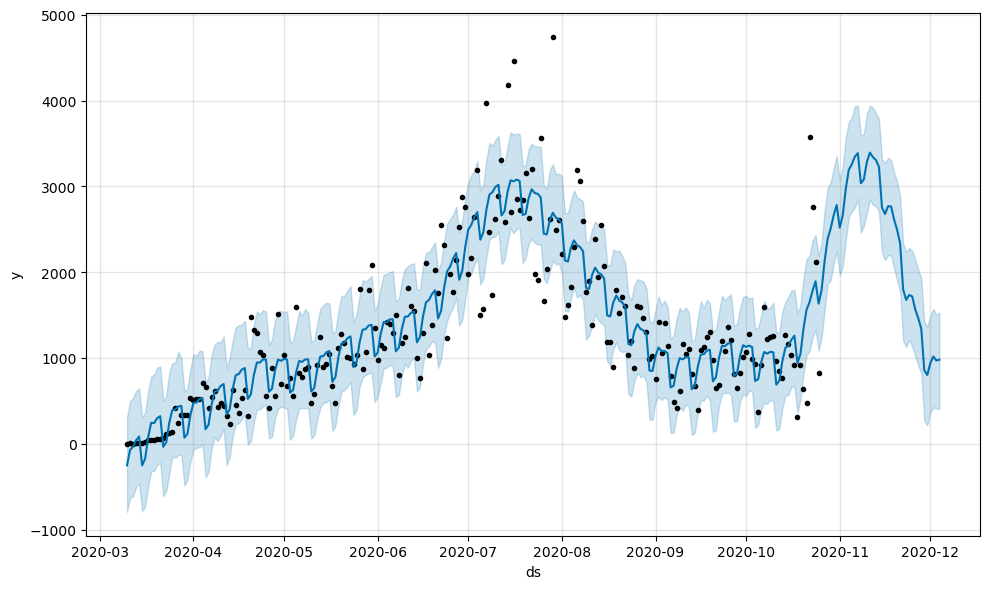

In [89]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

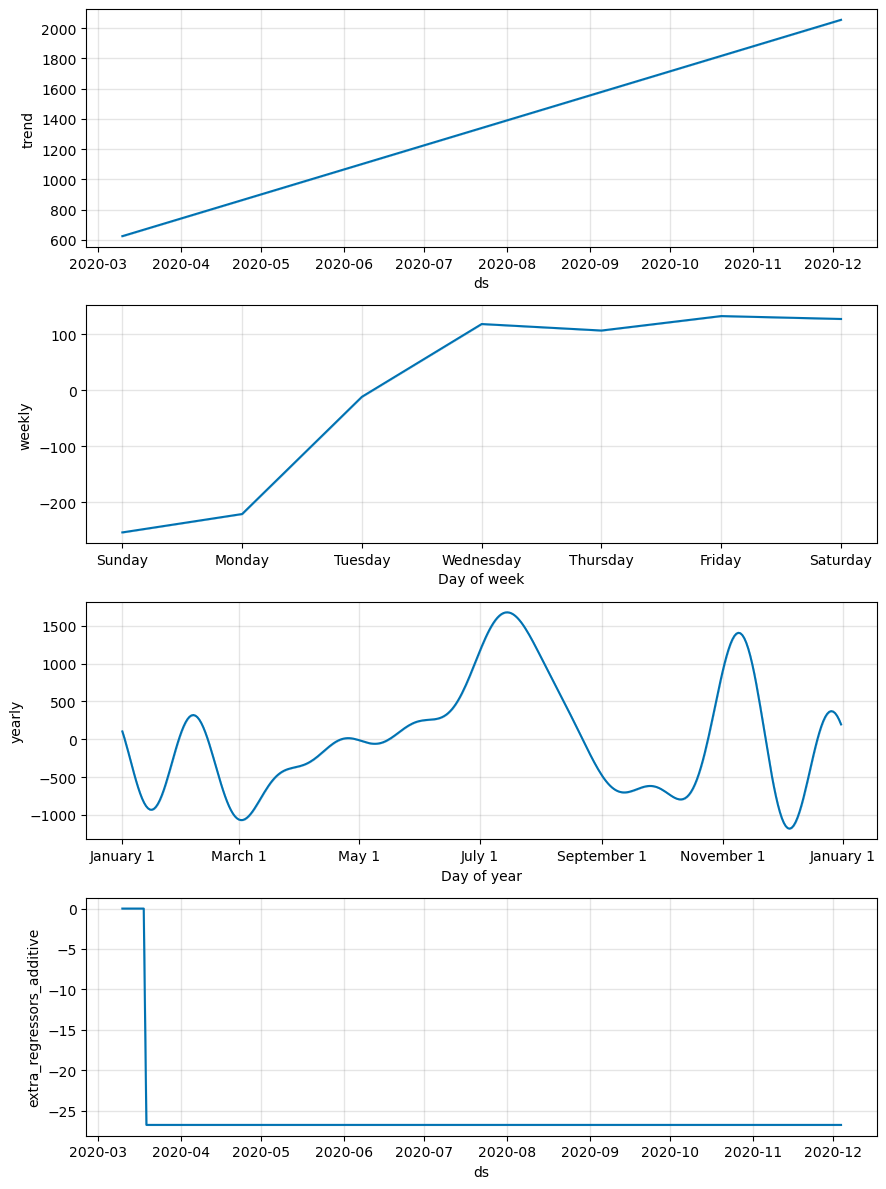

In [90]:
# Visualize the forecast components
model_multivariate.plot_components(forecast_multivariate);

In [91]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 2057.411106243787
The MAPE for the multivariate model is 0.6325188957103169


-1.025305678155389


<Axes: xlabel='date'>

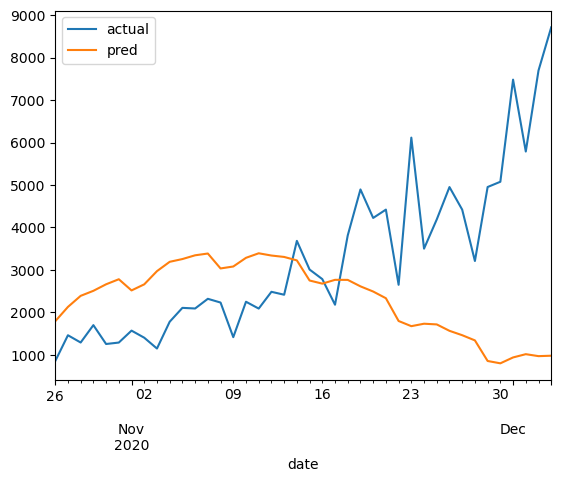

In [92]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [93]:
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_multivariate.add_regressor('stay_at_home_effective', standardize=False)
model_multivariate.add_regressor('stay_at_home_announced', standardize=False)
model_multivariate.fit(train)
future_multivariate = model_multivariate.make_future_dataframe(periods=40)
future_multivariate = pd.merge(future_multivariate, la[['ds', 'stay_at_home_effective', 'stay_at_home_announced']], on='ds', how='inner')
future_multivariate = future_multivariate.fillna(method='ffill')
future_multivariate.tail(10)

,ds,stay_at_home_effective,stay_at_home_announced
260,2020-11-25,1,1
261,2020-11-26,1,1
262,2020-11-27,1,1
263,2020-11-28,1,1
264,2020-11-29,1,1
265,2020-11-30,1,1
266,2020-12-01,1,1
267,2020-12-02,1,1
268,2020-12-03,1,1
269,2020-12-04,1,1


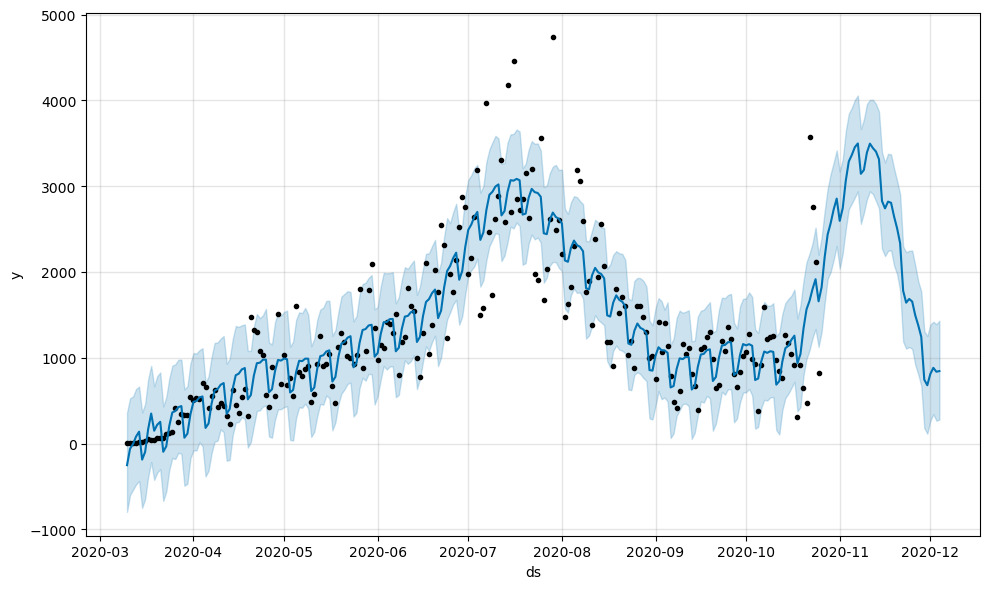

In [94]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

In [95]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 2120.9155381593937
The MAPE for the multivariate model is 0.6598761682802478


-1.1250164610902145


<Axes: xlabel='date'>

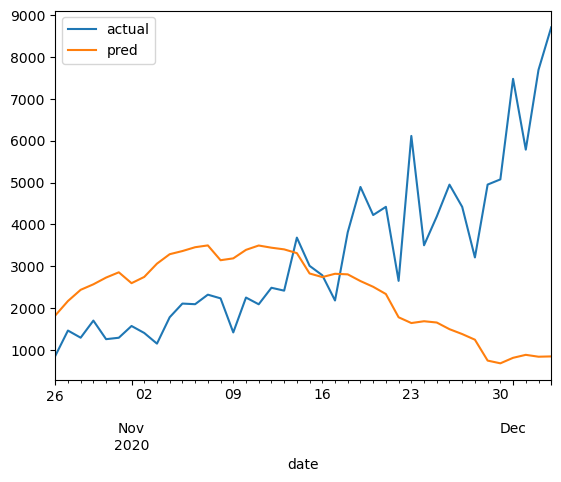

In [96]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [97]:
non_static_col = ['stay_at_home_announced', 'stay_at_home_effective', 'mean_temp',
       'min_temp', 'max_temp', 'dewpoint', 'visibility',
       'wind_speed', 'max_wind_speed',  'fog',
       'rain', 'snow', 'hail', 'thunder', 'tornado', 'mean_temp_3d_avg',
       'max_temp_3d_avg', 'min_temp_3d_avg', 'dewpoint_3d_avg']

model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)
for i in non_static_col:
  model_multivariate.add_regressor(i, standardize=False)
model_multivariate.fit(train)

In [98]:
non_static_col.append('ds')

In [99]:
future_multivariate = model_multivariate.make_future_dataframe(periods=40)

# Append the regressor values
future_multivariate = pd.merge(future_multivariate, la[non_static_col], on='ds', how='inner')

# Fill the missing values with the previous value
future_multivariate = future_multivariate.fillna(method='ffill')

# Check the data
future_multivariate.tail(10)

,ds,stay_at_home_announced,stay_at_home_effective,mean_temp,min_temp,max_temp,dewpoint,visibility,wind_speed,max_wind_speed,fog,rain,snow,hail,thunder,tornado,mean_temp_3d_avg,max_temp_3d_avg,min_temp_3d_avg,dewpoint_3d_avg
260,2020-11-25,1,1,58.7,53.6,64.4,38.9,10.0,0.4,2.9,0.0,0.0,0.0,0.0,0.0,0.0,61.700000,66.2,56.6,35.366667
261,2020-11-26,1,1,58.7,53.6,64.4,38.9,10.0,0.4,2.9,0.0,0.0,0.0,0.0,0.0,0.0,61.700000,66.2,56.6,35.366667
262,2020-11-27,1,1,65.3,64.4,66.2,25.7,10.0,6.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0,60.866667,65.0,57.8,28.466667
263,2020-11-28,1,1,58.6,55.4,64.4,20.8,10.0,1.0,5.1,0.0,0.0,0.0,0.0,0.0,0.0,64.066667,69.2,58.4,19.766667
264,2020-11-29,1,1,58.6,55.4,64.4,20.8,10.0,1.0,5.1,0.0,0.0,0.0,0.0,0.0,0.0,64.066667,69.2,58.4,19.766667
265,2020-11-30,1,1,68.3,55.4,77.0,12.8,10.0,3.6,5.1,0.0,0.0,0.0,0.0,0.0,0.0,64.066667,69.2,58.4,19.766667
266,2020-12-01,1,1,68.3,55.4,77.0,12.8,10.0,3.6,5.1,0.0,0.0,0.0,0.0,0.0,0.0,64.066667,69.2,58.4,19.766667
267,2020-12-02,1,1,68.3,55.4,77.0,12.8,10.0,3.6,5.1,0.0,0.0,0.0,0.0,0.0,0.0,64.066667,69.2,58.4,19.766667
268,2020-12-03,1,1,68.3,55.4,77.0,12.8,10.0,3.6,5.1,0.0,0.0,0.0,0.0,0.0,0.0,64.066667,69.2,58.4,19.766667
269,2020-12-04,1,1,68.3,55.4,77.0,12.8,10.0,3.6,5.1,0.0,0.0,0.0,0.0,0.0,0.0,64.066667,69.2,58.4,19.766667


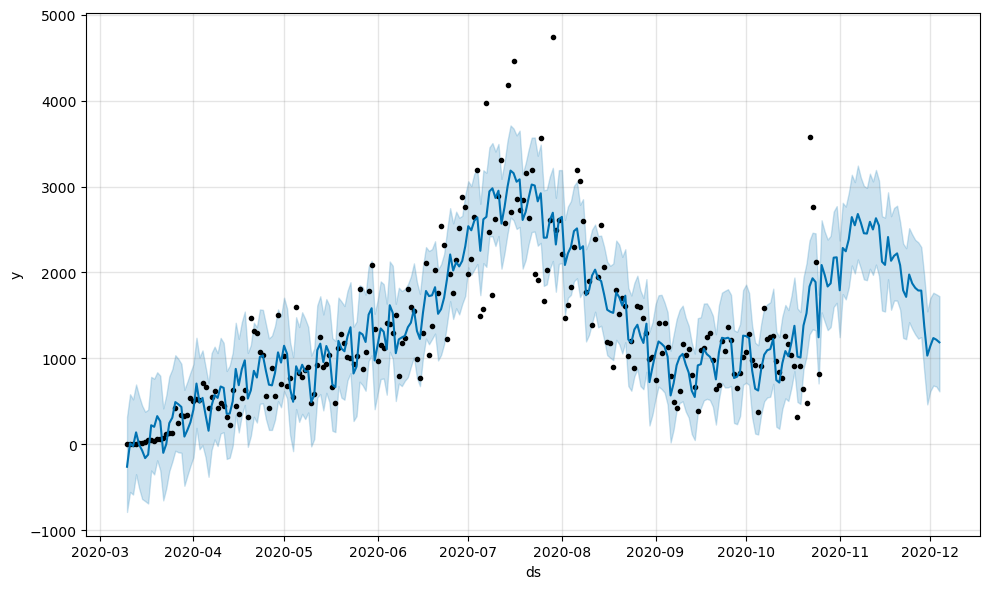

In [100]:
# Make prediction
forecast_multivariate = model_multivariate.predict(future_multivariate)

# Visualize the forecast
model_multivariate.plot(forecast_multivariate); # Add semi-colon to remove the duplicated chart

In [101]:
# Merge actual and predicted values
performance_multivariate = pd.merge(test, forecast_multivariate[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-40:], on='ds')

# Check MAE value
performance_multivariate_MAE = mean_absolute_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAE for the multivariate model is {performance_multivariate_MAE}')

# Check MAPE value
performance_multivariate_MAPE = mean_absolute_percentage_error(performance_multivariate['y'], performance_multivariate['yhat'])
print(f'The MAPE for the multivariate model is {performance_multivariate_MAPE}')

The MAE for the multivariate model is 1780.0436438247361
The MAPE for the multivariate model is 0.4809478574095922


-0.7931833672813433


<Axes: xlabel='date'>

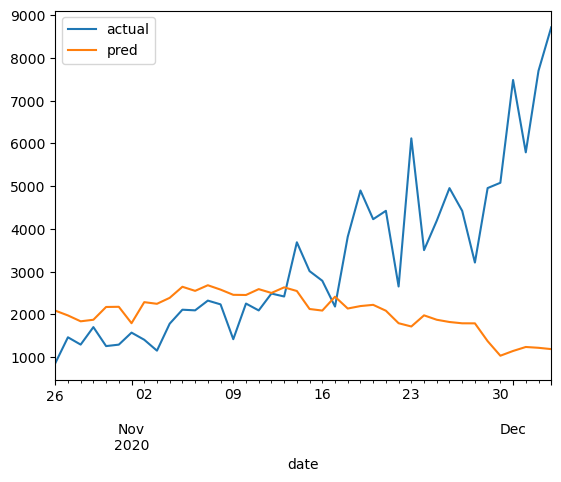

In [102]:
pred = forecast_multivariate.loc[:, ['ds', 'yhat']][-40:].yhat
r2 = r2_score(test.y, pred)
print(r2)

prediction = pd.DataFrame({'actual':test.y.reset_index(drop = True),
              'pred':pred.reset_index(drop = True)})
prediction['date'] = test.ds.reset_index(drop = True)
prediction.plot(x = 'date', y = ['actual', 'pred'])

In [ ]:
# COVID time window
COVID = pd.DataFrame({
    'holiday': 'COVID',
    'ds': pd.to_datetime(['2020-03-15']),
    'lower_window': -15,
    'upper_window': 15,
})

# Super Bowl time window
superbowl = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2020-02-02', '2021-02-07']),
    'lower_window': -7,
    'upper_window': 1,
})

# Combine all events
events = pd.concat((COVID, superbowl))

# Take a look at the events data
events

# Add holidays
model_holiday = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=events)

# Add built-in country-specific holidays
model_holiday.add_country_holidays(country_name='US')

# Add regressor
model_holiday.add_regressor('stay_at_home_announced', standardize=False)

# Fit the model on the training dataset
model_holiday.fit(train)

# All the holidays and events
model_holiday.train_holiday_names

0                           COVID
1                       superbowl
2                  New Year's Day
3                    Memorial Day
4                Independence Day
5     Independence Day (observed)
6                       Labor Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10     Martin Luther King Jr. Day
11          Washington's Birthday
12                   Columbus Day
dtype: object

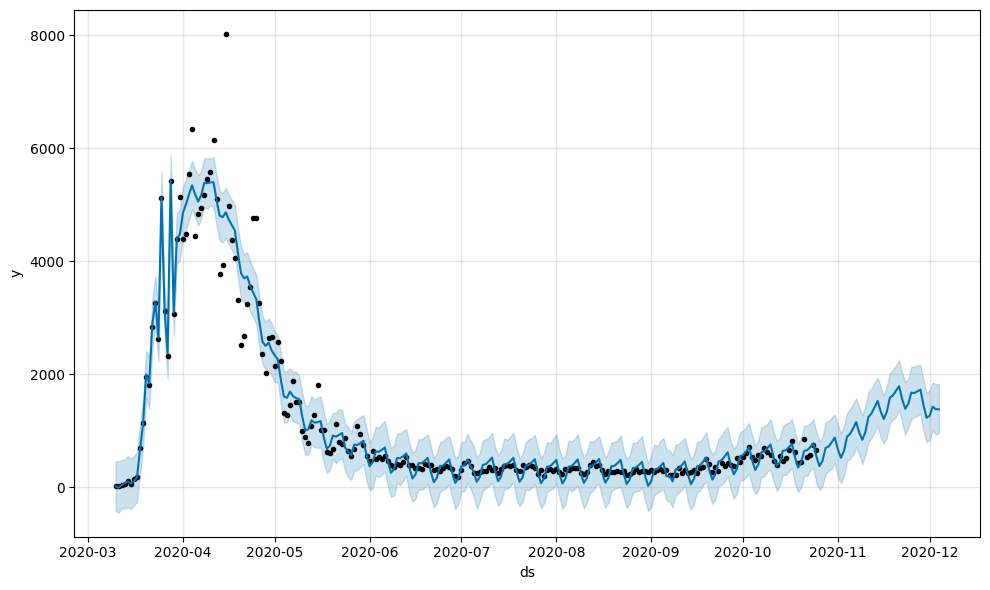

In [ ]:
# Create the time range for the forecast
future_holiday = model_holiday.make_future_dataframe(periods=40)

# Append the regressor values
future_holiday = pd.merge(future_holiday, nyc[['ds', 'stay_at_home_announced']], on='ds', how='inner')

# Fill the missing values with the previous value
future_holiday = future_holiday.fillna(method='ffill')

# Make prediction
forecast_holiday = model_holiday.predict(future_holiday)

# Visualize the forecast
model_holiday.plot(forecast_holiday); # Add semi-colon to remove the duplicated chart

In [ ]:
# Merge actual and predicted values
performance_holiday = pd.merge(test, forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_holiday_MAE = mean_absolute_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAE for the holiday/event model is {performance_holiday_MAE}')

# Check MAPE value
performance_holiday_MAPE = mean_absolute_percentage_error(performance_holiday['y'], performance_holiday['yhat'])
print(f'The MAPE for the holiday/event model is {performance_holiday_MAPE}')

The MAE for the holiday/event model is 828.5121380476444
The MAPE for the holiday/event model is 0.3126717216948625


In [ ]:
# Add seasonality
model_multivariate = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add regressor
model_multivariate.add_regressor('max_temp', standardize=False)

# Fit the model on the training dataset
model_multivariate.fit(nyc)

ValueError: Found NaN in column 'max_temp'

In [ ]:


# Assuming you have a DataFrame 'df' with timestamp, target variable, and related variables
# df = ...

# Separate target variable and related variables
target_variable = df[['timestamp', 'target_variable']]
related_variable_1 = df[['timestamp', 'related_variable_1']]
related_variable_2 = df[['timestamp', 'related_variable_2']]

# Prepare target variable DataFrame
target_variable.columns = ['ds', 'y']

# Create and fit Prophet model for target variable
model_target_variable = Prophet()
model_target_variable.fit(target_variable)

# Prepare related variable DataFrames
related_variable_1.columns = ['ds', 'y']
related_variable_2.columns = ['ds', 'y']

# Create and fit Prophet models for related variables
model_related_variable_1 = Prophet()
model_related_variable_1.fit(related_variable_1)

model_related_variable_2 = Prophet()
model_related_variable_2.fit(related_variable_2)

# Make forecasts
future_target_variable = model_target_variable.make_future_dataframe(periods=30)
forecast_target_variable = model_target_variable.predict(future_target_variable)

future_related_variable_1 = model_related_variable_1.make_future_dataframe(periods=30)
forecast_related_variable_1 = model_related_variable_1.predict(future_related_variable_1)

future_related_variable_2 = model_related_variable_2.make_future_dataframe(periods=30)
forecast_related_variable_2 = model_related_variable_2.predict(future_related_variable_2)

# Further processing and integration of forecasts as needed
